In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm


In [2]:
env = gym.make('CartPole-v1')

## REINFORCE Algorithm

Main concept behind REINFORCE is that we are trying to optimize the following objective function:

$$
J(\theta) = \mathbf{E}[\sum_{t=0}^{T - 1} r_{t+1} | \pi_{\theta}] \\
\qquad = \sum_{t=i}^{T - 1} P(s_t, a_t | \tau) r_{t+1}
$$

After some derivation, we find that the gradient for this is given by: 

$$
\nabla_{\theta}J(\theta) = \sum_{t = 0}^{T - 1} \nabla_{\theta} \log \pi_{\theta} (a_t | s_t) v_t
$$

We can then collect batches of episodes and update the policy by simply updating parameters with log gradient of policy scaled by returns: $\alpha \nabla_{\theta} \log \pi_{\theta}(s_t, a_t) v_t$


In [21]:
w = np.random.rand(4, 2)

config = {
    "num_episodes": 10000,
    "learning_rate": 2.5e-5,
    "gamma": 0.99
}

runs = []
for i in tqdm(range(config["num_episodes"])):
    data = run_episode(env, policy(w))
    w = train_on_ep(w, data["grads"], data["rewards"], config)

    runtime = len(data["rewards"])
    runs.append(runtime)


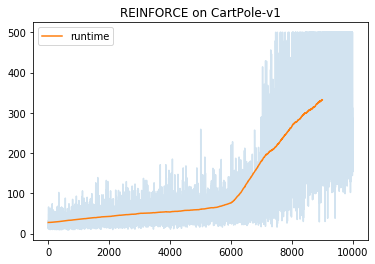

In [25]:
plt.plot(runs, alpha=0.2)
plt.plot(smooth(runs, 1000), label="runtime")
plt.title("REINFORCE on CartPole-v1")
plt.legend()
plt.show()

In [20]:
# Use a simple softmax as policy
def policy(w):
    def p(s):
        z = s.dot(w)
        exp = np.exp(z)
        return exp / np.sum(exp)
    
    return p

def softmax_grad(probs):
    s = probs.reshape(-1, 1)
    return np.diagflat(s) - np.dot(s, s.T)

def policy_gradient(state, action, probs):
    dsoftmax = softmax_grad(probs)[action, :]
    dlog = dsoftmax / probs[0, action]
    return state.T.dot(dlog[None, :])

def ep_return(rewards, i, gamma):
    return sum([r * (gamma ** t) for t, r in enumerate(rewards[i:])])

def run_episode(env, pi):
    state = env.reset()[None, :]

    grads = []
    rewards = []

    while True:
        # env.render()
        probs = pi(state)
        action = np.random.choice(env.action_space.n, p=probs[0])

        next_state, reward, done, _ = env.step(action)
        next_state = next_state[None, :]

        grads.append(policy_gradient(state, action, probs))
        rewards.append(reward)

        state = next_state

        if done: 
            break
    return {"grads": grads, "rewards": rewards}

def train_on_ep(w, grads, rewards, config):
    gamma = config["gamma"]
    lr = config["learning_rate"]
    for i, grad in enumerate(grads):
        w += lr * grad * ep_return(rewards, i, gamma)
    
    return w

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth